In [ ]:
%cd ./drive/MyDrive/Python/Machine Learning/Computer Vision/darknet-COCO-object_detection

/content/drive/MyDrive/Python/Machine Learning/Computer Vision/darknet-COCO-object_detection


In [ ]:
!pip install filterpy --quiet

# Download Files

In [ ]:
# I will create a different git repo for this work, so clone to a separate folder
!git clone https://github.com/cfotache/pytorch_objectdetecttrack.git

Cloning into 'pytorch_objectdetecttrack'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 36 (delta 5), reused 2 (delta 2), pack-reused 19
Unpacking objects: 100% (36/36), done.


In [ ]:
%ls

cnn-resnet-CIFAR10/             feedforward-cnn-MNIST/
darknet-COCO-object_detection/  pytorch_objectdetecttrack/


In [ ]:
!cp -r ./pytorch_objectdetecttrack/* ./darknet-COCO-object_detection/

In [ ]:
%ls ./darknet-COCO-object_detection

 config/                          PyTorch_Object_Tracking.ipynb
 images/                          README.md
'Jupyternote Cheatsheet.ipynb'    sort.py
 models.py                        Untitled0.ipynb
 object_tracker.py                utils/
 PyTorch_Object_Detection.ipynb


In [ ]:
%cd darknet-COCO-object_detection

/content/drive/MyDrive/Python/Machine Learning/Computer Vision/darknet-COCO-object_detection


# Code

## Download Weights

In [ ]:
%cd config

/content/drive/MyDrive/Python/Machine Learning/Computer Vision/darknet-COCO-object_detection/config


In [ ]:
%%sh
bash download_weights.sh

In [ ]:
%cd ..

/content/drive/MyDrive/Python/Machine Learning/Computer Vision/darknet-COCO-object_detection


## Imports

In [ ]:
from models import *
from utils import *

import os, sys, time, datetime, random

import torch
import torchvision.transforms as trf

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [ ]:
config_path = "config/yolov3.cfg"
weights_path = "config/yolov3.weights"
class_path = "config/coco.names"  # 80 classes

img_size = 416  
conf_thresh = 0.8 # confidence threshold
nms_thresh = 0.4  # non-max suppression threshold

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()
model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [ ]:
def show_image(image):
  """Display a single tensor or np array image"""
  fig, ax = plt.subplots(figsize=(12, 9))
  ax.set_yticks([]); ax.set_xticks([])
  ax.imshow(image.permute(1,2,0))

In [ ]:
def detect_image(img):
  """Runs Image detection on a single PIL Image"""
  # scale and pad image
  ratio = min(img_size/img.size[0], img_size/img.size[1])
  resized_w = round(img.size[0] * ratio)
  resized_h = round(img.size[1] * ratio)

  trfms = trf.Compose([trf.Resize((resized_h, resized_w)),
                       # left/right and top/bottom
                       trf.Pad((max(0, int((resized_h-resized_w)/2)),
                                max(0, int((resized_w-resized_h)/2)))),
                       trf.ToTensor()])
  
  img_tensor = trfms(img)
  # show a preview of the image
  # show_image(img_tensor)
  img_tensor = img_tensor.unsqueeze(0)

  with torch.no_grad():
    detections = model(img_tensor.cuda())
    detections = utils.non_max_suppression(detections, 80, conf_thresh, nms_thresh)

  return detections[0]

Inference Time: 0:00:00.146718


<Figure size 432x288 with 0 Axes>

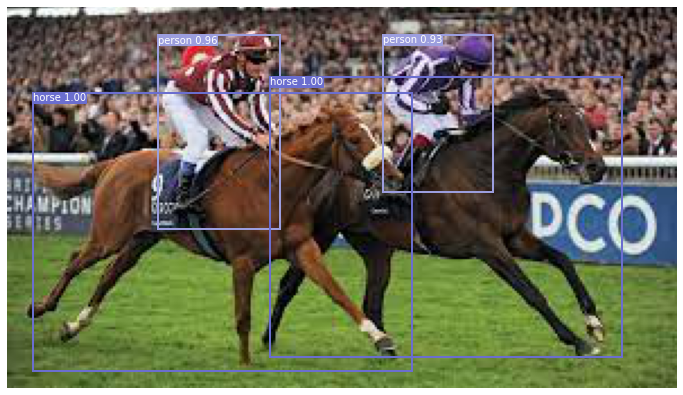

In [ ]:
from IPython.display import display

# load image and get detections
img_path = "images/sample3.jpg"
start_time = time.time()
img = Image.open(img_path)
detections = detect_image(img)
inference_time = datetime.timedelta(seconds=time.time() - start_time)
print(f"Inference Time: {inference_time}")

# Bounding Box Colours
cmap = plt.get_cmap('tab20b')
colors = [cmap(i) for i in np.linspace(0, 1, 20)]

# Create Image
img = np.array(img)
plt.figure()
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(img)

pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

if detections is not None:
  unique_labels = detections[:, -1].cpu().unique()
  n_cls_preds = len(unique_labels)
  bbox_colors = random.sample(colors, n_cls_preds)
  for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
    x1, y1 = x1.detach().cpu(), y1.detach().cpu()
    x2, y2 = x2.detach().cpu(), y2.detach().cpu()
    conf, cls_conf = conf.detach().cpu(), cls_conf.detach().cpu()

    box_h = ((y2 - y1) / unpad_h) * img.shape[0]
    box_w = ((x2 - x1) / unpad_w) * img.shape[1]
    y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
    x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]

    color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor=color, facecolor="none")
    ax.add_patch(bbox)
    plt.text(x1, y1, s=classes[int(cls_pred)] + " {0:.2f}".format(conf), 
             color="white", 
             verticalalignment="top", 
             bbox={'color': color, 'pad': 0})

plt.axis("off")
plt.savefig(img_path.replace(".jpg", "-det.jpg"), 
            bbox_inches="tight", pad_inches=0.0)
plt.show()

# Push to Hub

In [10]:
!pip install huggingface_hub --quiet

from huggingface_hub import notebook_login

     |████████████████████████████████| 86 kB 3.3 MB/s 
     |████████████████████████████████| 596 kB 33.1 MB/s 


In [11]:
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [15]:
from huggingface_hub import upload_file, delete_file

# upload_file("path_to_file", "path_in_repo", "repo_id", )
upload_file("darknet-coco-object_detection.ipynb", 
            "darknet-coco-object_detection.ipynb", 
            "danieladejumo/darknet-coco-object_detection")

delete_file("darknet-coco-object_detection.ipynb", 
            "danieladejumo/darknet-coco-object_detection")

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass path_or_fileobj='darknet-coco-object_detection.ipynb', path_in_repo='darknet-coco-object_detection.ipynb', repo_id='danieladejumo/darknet-coco-object_detection' as keyword args. From version 0.8 passing these as positional arguments will result in an error
  FutureWarning,


'https://huggingface.co/danieladejumo/darknet-coco-object_detection/blob/main/darknet-coco-object_detection.ipynb'

In [38]:
%%bash
git init
git branch -M main
git remote add origin https://huggingface.co/danieladejumo/darknet-coco-object_detection
git pull origin main

Initialized empty Git repository in /content/drive/MyDrive/Python/Machine Learning/Computer Vision/darknet-COCO-object_detection/.git/


error: refname refs/heads/master not found
fatal: Branch rename failed
From https://huggingface.co/danieladejumo/darknet-coco-object_detection
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main
error: The following untracked working tree files would be overwritten by merge:
	.gitattributes
	README.md
Please move or remove them before you merge.
Aborting


In [22]:
from huggingface_hub import Repository

repo = Repository("./")

In [ ]:
repo.git_add()
repo.git_commit("Files Commit")
repo.git_push()

In [33]:
!touch .gitignore

In [34]:
%%writefile .gitignore
images/*
videos/*
config/*

Overwriting .gitignore


In [37]:
!rm -r .git